# Kandinsky Patterns

## Lab 3

Tymoteusz Barciński, Agata Kaczmarek, Mateusz Stączek

### How sure the models are when making predictions?


#### Loading and processing (scaling) data

Link to original code for generating: https://github.com/human-centered-ai-lab/app-kandinsky-pattern-generator

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import torch
import torchvision
from  torchvision.datasets import ImageFolder 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from torchvision import models
import os
import torch.nn.functional as F
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cpu


In [ ]:
folder = '/work/newly_generated_data/shapeonshapes_1k'

classes = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]
classes = [classes[2], classes[1], classes[0]] 

print(f"Classes found: {classes}")

Classes found: ['counterfactual', 'false', 'true']


#### Creating data loaders.

In [ ]:
num_classes = 3
batch_size=16

train_size=2500
test_size=250
val_size=250


transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize([256, 256])])

train_set = ImageFolder('/work/newly_generated_data/shapeonshapes_1k', transform = transform)

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(train_set,
                                               [train_size, test_size, val_size])
trainloader = torch.utils.data.DataLoader(
     train_dataset, batch_size=batch_size, shuffle=False)

testloader = torch.utils.data.DataLoader(
     test_dataset, batch_size=batch_size, shuffle=False)

valloader = torch.utils.data.DataLoader(
     val_dataset, batch_size=batch_size, shuffle=False)

#### Some helper functions

In [ ]:
def check_predictions(model, loader, print_acc = True, return_results = False):
    total=0
    correct=0
    probabilities = []
    is_correct = []

    for data in loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

        probabilities += nn.functional.softmax(outputs, dim=1).max(dim=1).values.detach().numpy().tolist()
        is_correct += (pred == labels).numpy().tolist()
    if print_acc:
        print(f"Accuracy is: {100 * correct / total}")
    if return_results:
        return np.array(is_correct), np.array(probabilities)

In [ ]:
def plot_hist(models, loader, model_names):
    facecolors = ['g','b','r']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    ax2.set_xlim((0,1))
    ax1.set_xlim((0,1))

    for model, model_name, facecolor in zip(models, model_names, facecolors):
        is_correct_np, probabilities_np = check_predictions(model, loader, print_acc=False, return_results=True)
        ax1.hist(probabilities_np[is_correct_np], 
            50, density=True, facecolor=facecolor, alpha=0.3, label=model_name,range=(0,1))
        ax2.hist(probabilities_np[np.invert(is_correct_np)],
            50, density=True, facecolor=facecolor, alpha=0.3, label=model_name,range=(0,1))

    ax1.set_title("... correctly predicted samples.")
    ax1.set_xlabel("Probability")
    ax1.legend()

    ax2.set_title("... incorrectly predicted samples.")
    ax2.set_xlabel("Probability")
    ax2.legend()

    plt.suptitle(f"How sure the models ({' vs '.join(model_names)}) are on..", size=20,y=1.05)
    plt.show()

#### Probabilites: pretrained ResNet18

Let's check the accuracy on test set, if it is really that high.

In [ ]:
filename = 'finalized_model10.pth'
loaded_model=torch.load(filename)
check_predictions(loaded_model, testloader)

Accuracy is: 98.0


Then, let's see probabilities distribution for correct and incorrect predictions.

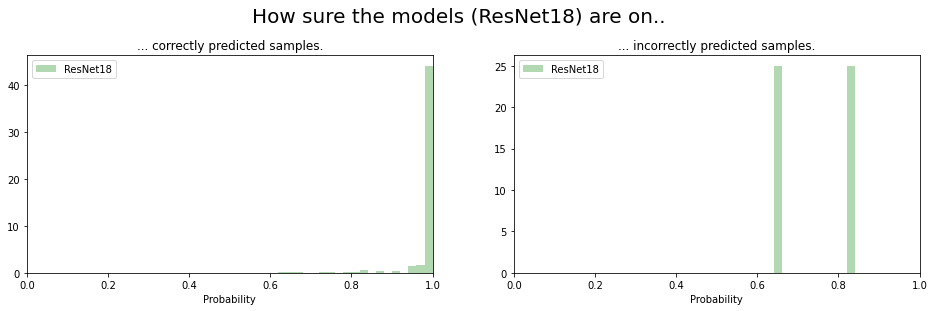

In [ ]:
plot_hist(models=[loaded_model], loader=testloader, model_names=["ResNet18"])

#### Probabilites: A simple CNN

In [ ]:
# model structure

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3,16,5,1)
        self.conv2 = nn.Conv2d(16,32,5,1)
        self.conv3 = nn.Conv2d(32,64,3,1)
        self.fc1 = nn.Linear(576, 128) 
        self.fc2 = nn.Linear(128, 3)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,4,4)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,4,4)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,4,4)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Accuracy is still rather high.

In [ ]:
PATH = 'models/simple_cnn_2.pth'
ours_cnn = SimpleCNN()
ours_cnn.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
check_predictions(ours_cnn, testloader)

Accuracy is: 96.8


Sometimes, our cnn is less sure when making incorrect predictions than Resnet18, sometimes it is more sure. 

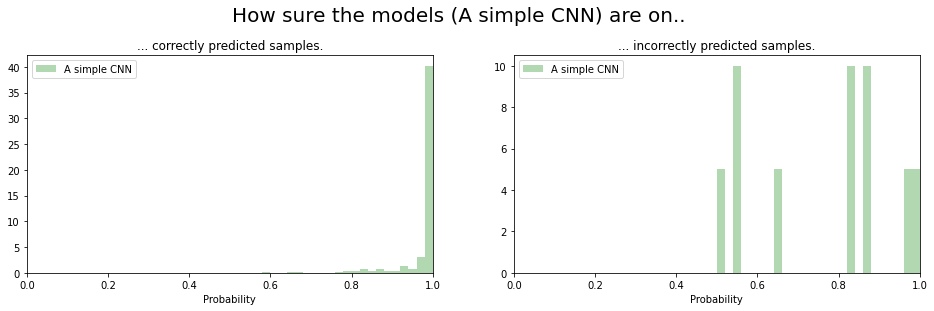

In [ ]:
plot_hist(models=[ours_cnn], loader=testloader, model_names=["A simple CNN"])

#### Probabilites: pretrained ResNet18 vs simple CNN

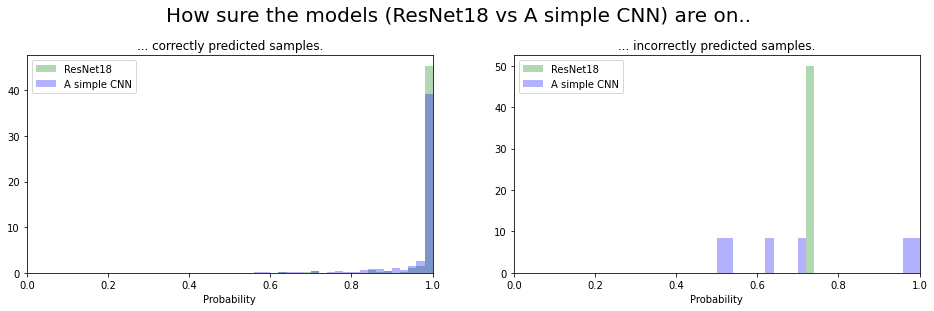

In [ ]:
print("Test set")
plot_hist(models=[loaded_model, ours_cnn], loader=testloader, model_names=["ResNet18", "A simple CNN"])
print("Test set")
plot_hist(models=[loaded_model, ours_cnn], loader=testloader, model_names=["ResNet18", "A simple CNN"])
print("Test set")
plot_hist(models=[loaded_model, ours_cnn], loader=testloader, model_names=["ResNet18", "A simple CNN"])

## Previous explanations

In [ ]:
total=0
correct=0
inputs, labels = next(iter(testloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = loaded_model(inputs)
_, pred = torch.max(outputs.data, 1)
total += labels.size(0)
correct += (pred == labels).sum().item()
print(100 * correct / total)

100.0


torch.Size([16, 3, 256, 256])
tensor([2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1])
tensor([2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1])
label: true, pred: true (0.9999715089797974)
label: false, pred: false (0.9860296845436096)
label: true, pred: true (0.9999983310699463)
label: counterfactual, pred: counterfactual (0.9981529116630554)
label: false, pred: false (0.9989344477653503)
label: true, pred: true (0.9990870952606201)
label: counterfactual, pred: counterfactual (0.9801185131072998)
label: true, pred: true (0.999373733997345)
label: false, pred: false (0.9994226694107056)
label: false, pred: false (0.9989515542984009)
label: counterfactual, pred: counterfactual (0.9887722134590149)
label: false, pred: false (0.999777615070343)
label: false, pred: false (0.9995386600494385)
label: counterfactual, pred: counterfactual (0.9920195937156677)
label: false, pred: false (0.9961251616477966)
label: false, pred: false (0.9969419836997986)


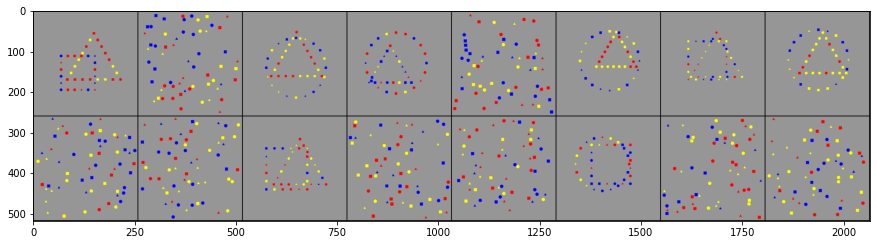

In [ ]:
print(inputs.shape)
print(labels)
print(pred)
grid_testing = torchvision.utils.make_grid(inputs, nrow=8)

plt.figure(figsize=(15,15))
plt.imshow(grid_testing.permute(1,2,0))

probabilities = nn.functional.softmax(outputs, dim=1).max(dim=1).values.detach().numpy()

for i in range(batch_size):
    print(f"label: {classes[labels[i]]}, pred: {classes[pred[i]]} ({probabilities[i]})")

<class 'torch.Tensor'>
true label: counterfactual
pred label: counterfactual
tensor(0)
0.9980185


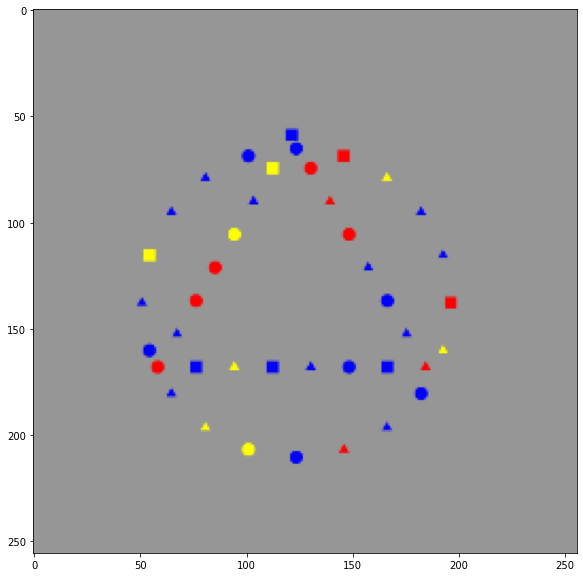

In [ ]:
print(type(inputs[1]))

grid_test = torchvision.utils.make_grid(inputs[0], nrow=10)

plt.figure(figsize=(10,10))
plt.imshow(grid_test.cpu().permute(1,2,0))

print(f'true label: {classes[labels[0]]}')
print(f'pred label: {classes[pred[0]]}')
print(labels[0]) # "2" stands for "true"
print(probabilities[0])

## Representation vector

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch
    preds = model(images)
    all_preds = torch.cat((all_preds, preds) ,dim=0)

  return all_preds

In [ ]:
import copy 
network_for_tsne = copy.deepcopy(ours_cnn)
network_for_tsne.fc2 = nn.Identity()
test_preds_tsne = get_all_preds(network_for_tsne, testloader)

In [ ]:
filename = 'finalized_model10.pth'
# torch.save(model, filename)
loaded_model_resnet = torch.load(filename)
loaded_model_resnet.fc = nn.Identity()
test_preds_resnet = get_all_preds(loaded_model_resnet, testloader)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#Simple CNN part
pca = PCA(n_components=50)
pca.fit(test_preds)
pca_features = pca.transform(test_preds)

tsne = TSNE().fit_transform(pca_features)
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

#Resnet18 part
pca_resnet = PCA(n_components=50)
pca_resnet.fit(test_preds_resnet)
pca_features_resnet = pca_resnet.transform(test_preds_resnet)

tsne_resnet = TSNE().fit_transform(pca_features_resnet)
tx_resnet, ty_resnet = tsne_resnet[:,0], tsne_resnet[:,1]
tx_resnet = (tx_resnet-np.min(tx_resnet)) / (np.max(tx_resnet) - np.min(tx_resnet))
ty_resnet = (ty_resnet-np.min(ty_resnet)) / (np.max(ty_resnet) - np.min(ty_resnet))

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


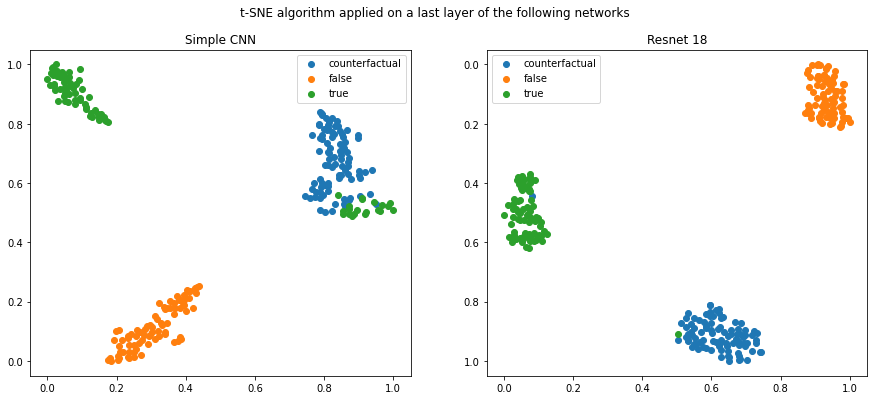

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('t-SNE algorithm applied on a last layer of the following networks')

y_test = np.array([i[1] for i in test_dataset]) # real labels
for i in range(len(classes)):
    y_i = y_test == i
    ax1.scatter(tx[y_i[:]], ty[y_i[:]], label=classes[i])
ax1.legend()
ax1.set_title('Simple CNN')

for i in range(len(classes)):
    y_i = y_test == i
    ax2.scatter(tx_resnet[y_i[:]], ty_resnet[y_i[:]], label=classes[i])
ax2.legend()
ax2.set_title('Resnet 18')

plt.gca().invert_yaxis()
plt.show()

### PCA

In [ ]:
test_preds

NameError: name 'test_preds' is not defined

In [ ]:
from sklearn.decomposition import PCA

#Simple CNN part
pca_features = PCA().fit_transform(test_preds)
pca_x, pca_y = pca_features[:,0], pca_features[:,1]
pca_x = (pca_x-np.min(pca_x)) / (np.max(pca_x) - np.min(pca_x))
pca_y = (pca_y-np.min(pca_y)) / (np.max(pca_y) - np.min(pca_y))

#Resnet18 part
pca_resnet = PCA().fit_transform(test_preds_resnet)
pca_x_resnet, pca_y_resnet = pca_resnet[:,0], pca_resnet[:,1]
pca_x_resnet = (pca_x_resnet-np.min(pca_x_resnet)) / (np.max(pca_x_resnet) - np.min(pca_x_resnet))
pca_y_resnet = (pca_y_resnet-np.min(pca_y_resnet)) / (np.max(pca_y_resnet) - np.min(pca_y_resnet))

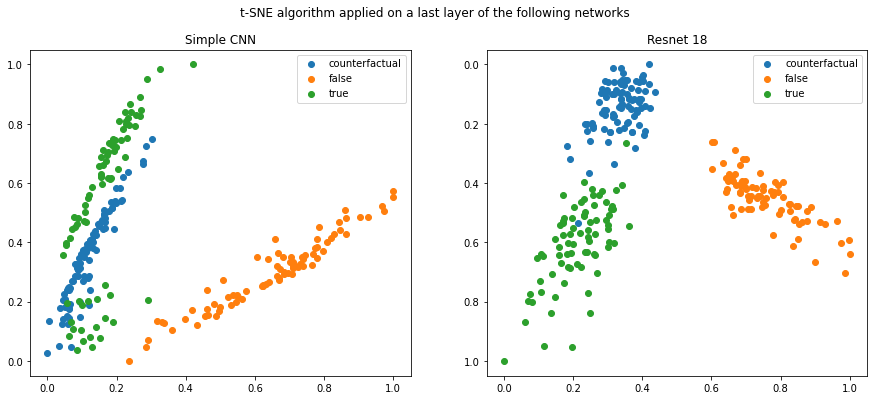

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('t-SNE algorithm applied on a last layer of the following networks')

y_test = np.array([i[1] for i in test_dataset]) # real labels
for i in range(len(classes)):
    y_i = y_test == i
    ax1.scatter(pca_x[y_i[:]], pca_y[y_i[:]], label=classes[i])
ax1.legend()
ax1.set_title('Simple CNN')

for i in range(len(classes)):
    y_i = y_test == i
    ax2.scatter(pca_x_resnet[y_i[:]], pca_y_resnet[y_i[:]], label=classes[i])
ax2.legend()
ax2.set_title('Resnet 18')

plt.gca().invert_yaxis()
plt.show()

# percentage of variance explained

### Attempt with probabilites

In [ ]:
probabilites_cnn = check_predictions(ours_cnn, testloader, return_results=True)[1]
probabilites_resnet = check_predictions(torch.load('finalized_model10.pth'), testloader, return_results=True)[1]

Accuracy is: 96.8
Accuracy is: 98.0


In [ ]:
data_df = np.transpose(np.array([tx, ty, probabilites_cnn, y_test]))
columns_df = ["tx", "ty", "probabilites_cnn", "y_test"]
df = pd.DataFrame(data = data_df, columns = columns_df)
df.head()

<AxesSubplot:>

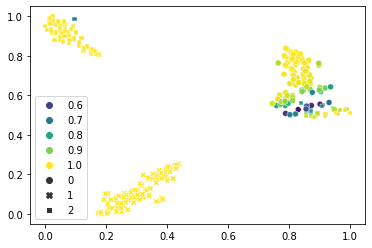

In [ ]:
sns.scatterplot(data = df, x = tx, y = ty, style = y_test, hue = probabilites_cnn, palette="viridis")

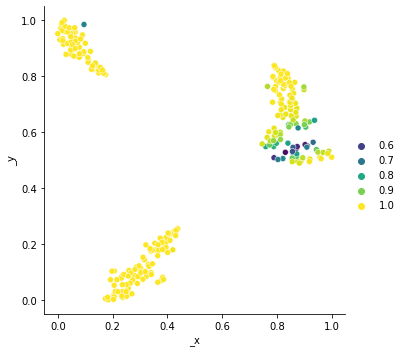

In [ ]:
sns.relplot(
    data = df, x = tx, y = ty, hue = probabilites_cnn, col=y_test, kind = "scatter", palette="viridis"
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


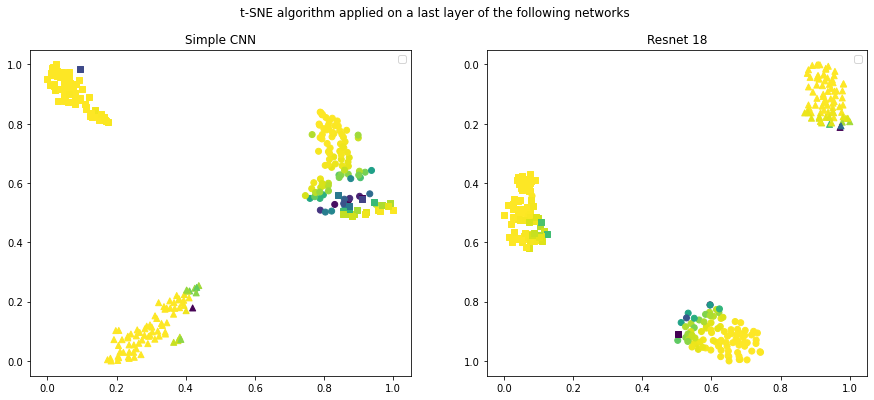

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('t-SNE algorithm applied on a last layer of the following networks')

y_test = np.array([i[1] for i in test_dataset]) # real labels
markers = ["o", "^", "s"]
for i in range(len(classes)):
    y_i = y_test == i
    ax1.scatter(tx[y_i[:]], ty[y_i[:]], c=probabilites_cnn[y_i[:]], marker=markers[i])
ax1.legend()
ax1.set_title('Simple CNN')

for i in range(len(classes)):
    y_i = y_test == i
    ax2.scatter(tx_resnet[y_i[:]], ty_resnet[y_i[:]], c=probabilites_resnet[y_i[:]], marker=markers[i])
ax2.legend()
ax2.set_title('Resnet 18')

plt.gca().invert_yaxis()
plt.show()

In [ ]:
data_df_pca = np.transpose(np.array([pca_x, pca_y, probabilites_cnn, y_test]))
columns_df = ["pca_x", "pca_y", "probabilites_cnn", "y_test"]
df_pca = pd.DataFrame(data = data_df_pca, columns = columns_df)

In [ ]:
df_pca["clustering"] = np.where(((df_pca.pca_y > 0.3) & (df_pca.y_test == 2)), 'cluster_true_1',
                        np.where(df_pca.y_test == 1, 'false',
                        np.where(df_pca.y_test == 2, "cluster_true_2", "counterfactual")))

<AxesSubplot:>

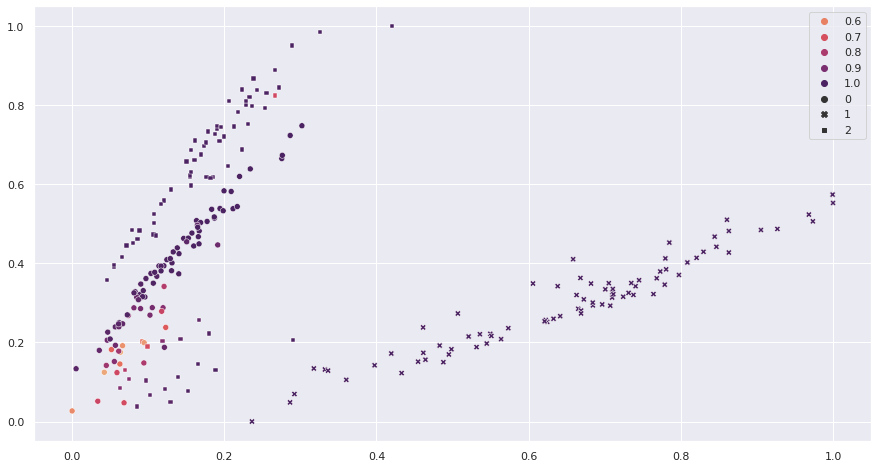

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.scatterplot(data = df_pca, x = pca_x, y = pca_y,
                style = y_test, hue = probabilites_cnn, palette="flare")

## Explanations
Various explanations are presented below, such as Lime, Shap and Integrated Gradients. For each class two pictures were examined. 


In [ ]:
%%capture
!pip install captum
!pip install scikit-image

In [ ]:
from captum.attr import Lime
from skimage import segmentation
from captum.attr import visualization
from captum.attr import IntegratedGradients
from captum.attr import KernelShap

#### Helper functions - explanations

In [ ]:
def compute_mask(image):
    mask = segmentation.quickshift(
        image.permute(1, 2, 0).double(), 
        kernel_size=50, 
        max_dist=7, 
        ratio=0.7
    )
    return mask

def show_attr_ig(attr_map, label):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True,
        title= f"Integrated Gradients - {classes[label]}"
    )

def show_attr_shap(attr_map, label):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True,
        title= f"Shap - {classes[label]}"
    )

def exp_shap(image, label, network, mask):
    exp = KernelShap(network)
    exp = exp.attribute(
        image.unsqueeze(0), 
        target=label, 
        n_samples=300, 
        feature_mask=torch.as_tensor(mask),
        show_progress=True
    )
    return exp

def exp_Lime(image, label, newtork, mask):
    explainer = Lime(newtork)
    attr = explainer.attribute(
        image.unsqueeze(0),
        target=label, 
        n_samples=20, 
        feature_mask=torch.as_tensor(mask),
        show_progress=True
    )
    return attr

def exp_ig(image, label, newtork):
    exp_ig = IntegratedGradients(newtork)
    attr_ig = exp_ig.attribute(image.unsqueeze(0), target=label)
    return attr_ig  

def show_image_mask_explanation(image, mask, explanation, label):
    fig, ax = plt.subplots(1, 3, figsize=[6 * 2, 6])
    fig.suptitle(f'Lime Explanations - {classes[label]}', fontsize=20,y=0.85)
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title("image")
    ax[1].imshow(mask, cmap="flag")
    ax[1].set_title("segmentation mask")
    ax[2].imshow(explanation, vmin=-1, vmax=1, cmap="RdBu")
    ax[2].set_title("explanation")
    plt.show()

def compute_mask_for_item(number):
    inputs, labels = next(iter(testloader))
    image = inputs[number]
    label = labels[number].item()
    mask = compute_mask(image)
    return image, label, mask

def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

def show_attr_abs(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='absolute_value',
        show_colorbar=True
    )

def normalize_anything(attr_map, str_sign):
    return visualization._normalize_image_attr(attr_map.permute(1, 2, 0).numpy(), sign=str_sign, outlier_perc=2)

#### Example 1 - True

In [ ]:
image, label, mask = compute_mask_for_item(0)

Lime attribution: 100%|██████████| 20/20 [00:00<00:00, 125.39it/s]


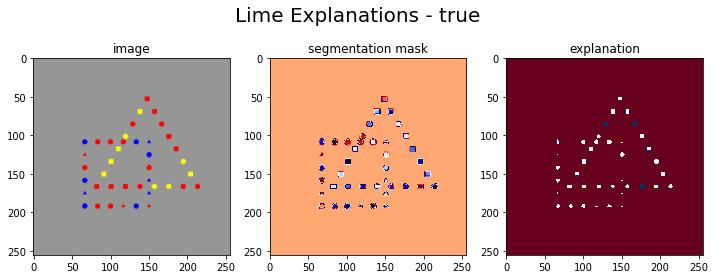

In [ ]:
attr_lime = exp_Lime(image, label, ours_cnn, mask)
show_image_mask_explanation(image, mask, attr_lime[0].mean(axis=0)*100000, label)

Kernel Shap attribution: 100%|██████████| 300/300 [00:03<00:00, 83.56it/s]


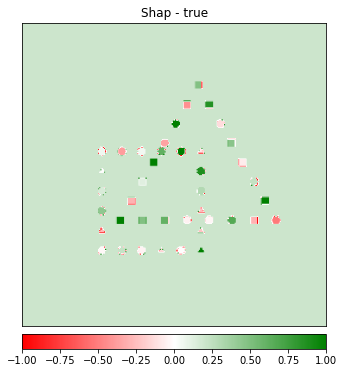

In [ ]:
attr_shap = exp_shap(image, label, ours_cnn, mask)
show_attr_shap(attr_shap[0], label)

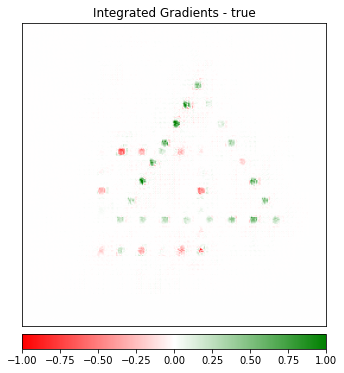

In [ ]:
attr_ig = exp_ig(image, label, ours_cnn)
show_attr_ig(attr_ig[0], label)

#### Example 2 - True

In [ ]:
image, label, mask = compute_mask_for_item(2)

Lime attribution: 100%|██████████| 20/20 [00:00<00:00, 119.54it/s]


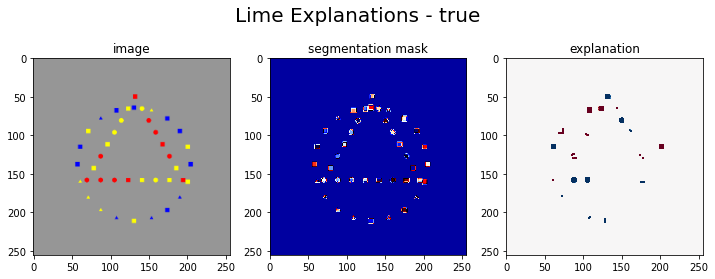

In [ ]:
attr_lime = exp_Lime(image, label, ours_cnn, mask)
show_image_mask_explanation(image, mask, attr_lime[0].mean(axis=0)*100000, label)

Kernel Shap attribution: 100%|██████████| 300/300 [00:05<00:00, 55.34it/s]


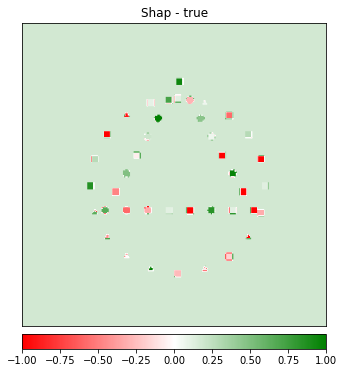

In [ ]:
attr_shap = exp_shap(image, label, ours_cnn, mask)
show_attr_shap(attr_shap[0], label)

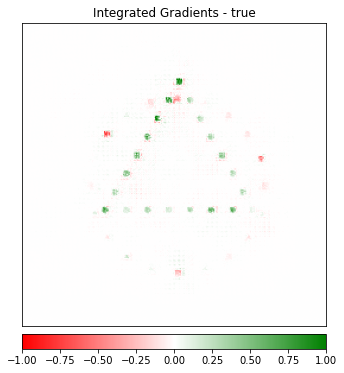

In [ ]:
attr_ig = exp_ig(image, label, ours_cnn)
show_attr_ig(attr_ig[0], label)

#### Example 3 - Counterfactual

In [ ]:
image, label, mask = compute_mask_for_item(3)

Lime attribution: 100%|██████████| 20/20 [00:00<00:00, 120.40it/s]
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.079e-02, tolerance: 6.867e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


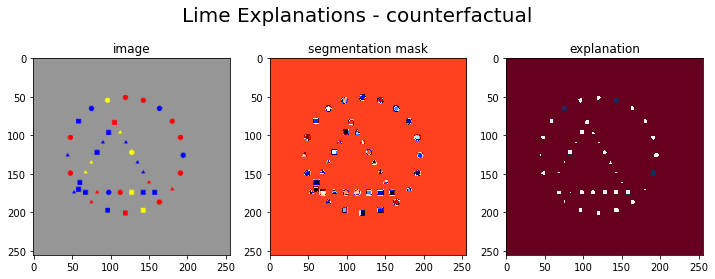

In [ ]:
attr_lime = exp_Lime(image, label, ours_cnn, mask)
show_image_mask_explanation(image, mask, attr_lime[0].mean(axis=0)*100000, label)

Kernel Shap attribution: 100%|██████████| 300/300 [00:03<00:00, 87.70it/s]


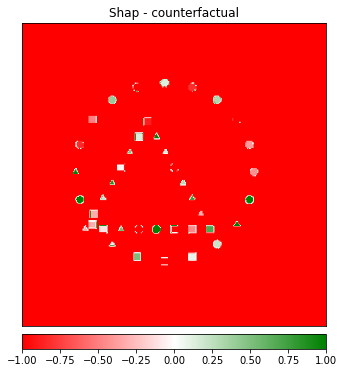

In [ ]:
attr_shap = exp_shap(image, label, ours_cnn, mask)
show_attr_shap(attr_shap[0], label)

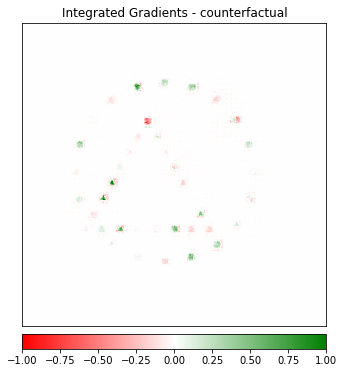

In [ ]:
attr_ig = exp_ig(image, label, ours_cnn)
show_attr_ig(attr_ig[0], label)

#### Example 4 - Counterfactual

In [ ]:
image, label, mask = compute_mask_for_item(6)

Lime attribution: 100%|██████████| 20/20 [00:00<00:00, 116.84it/s]


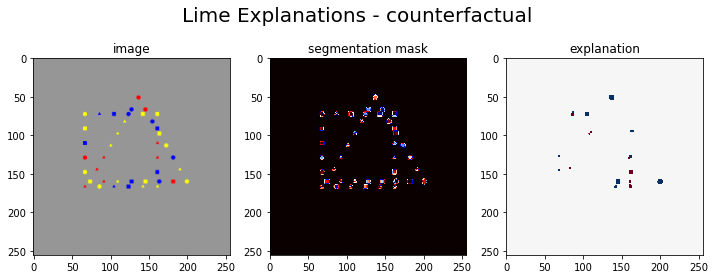

In [ ]:
attr_lime = exp_Lime(image, label, ours_cnn, mask)
show_image_mask_explanation(image, mask, attr_lime[0].mean(axis=0)*100000, label)

Kernel Shap attribution: 100%|██████████| 300/300 [00:03<00:00, 89.68it/s]


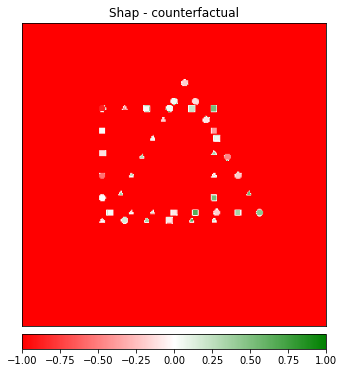

In [ ]:
attr_shap = exp_shap(image, label, ours_cnn, mask)
show_attr_shap(attr_shap[0], label)

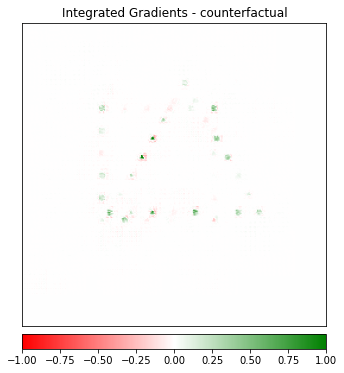

In [ ]:
attr_ig = exp_ig(image, label, ours_cnn)
show_attr_ig(attr_ig[0], label)

#### Example 5 - false

In [ ]:
image, label, mask = compute_mask_for_item(1)

Lime attribution: 100%|██████████| 20/20 [00:00<00:00, 118.78it/s]


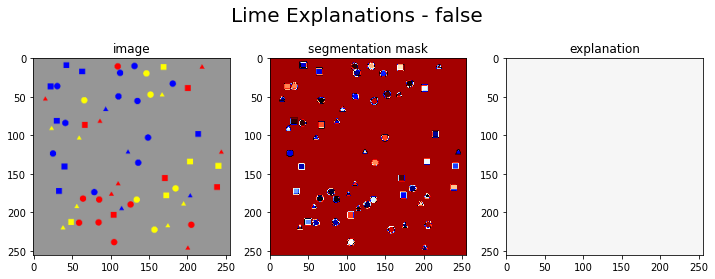

In [ ]:
attr_lime = exp_Lime(image, label, ours_cnn, mask)
show_image_mask_explanation(image, mask, attr_lime[0].mean(axis=0)*100000, label)

Kernel Shap attribution: 100%|██████████| 300/300 [00:03<00:00, 85.67it/s]


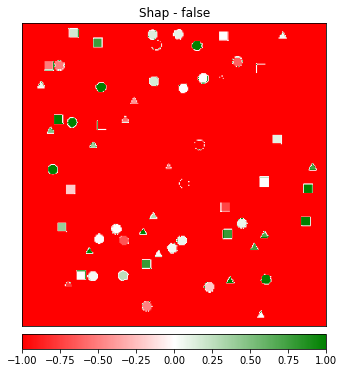

In [ ]:
attr_shap = exp_shap(image, label, ours_cnn, mask)
show_attr_shap(attr_shap[0], label)

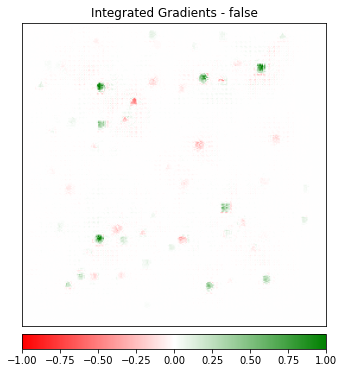

In [ ]:
attr_ig = exp_ig(image, label, ours_cnn)
show_attr_ig(attr_ig[0], label)

#### Example 6 - false

In [ ]:
image, label, mask = compute_mask_for_item(4)

Lime attribution: 100%|██████████| 20/20 [00:00<00:00, 129.08it/s]


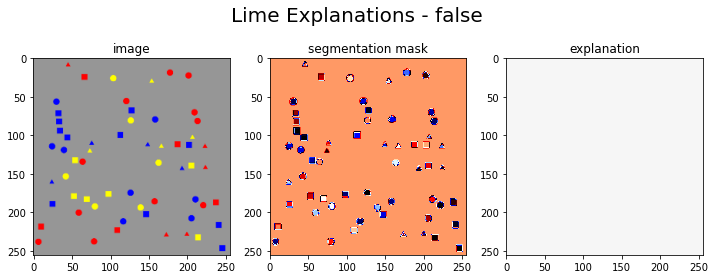

In [ ]:
attr_lime = exp_Lime(image, label, ours_cnn, mask)
show_image_mask_explanation(image, mask, attr_lime[0].mean(axis=0)*100000, label)

Kernel Shap attribution: 100%|██████████| 300/300 [00:03<00:00, 83.88it/s]


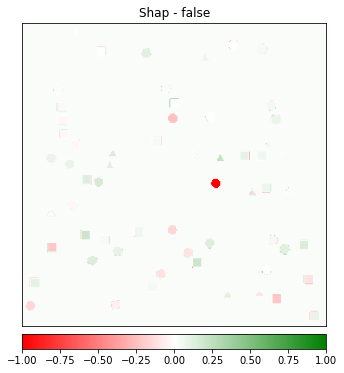

In [ ]:
attr_shap = exp_shap(image, label, ours_cnn, mask)
show_attr_shap(attr_shap[0], label)

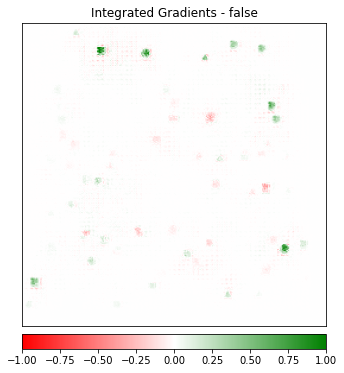

In [ ]:
attr_ig = exp_ig(image, label, ours_cnn)
show_attr_ig(attr_ig[0], label)

### Explanations on new CNN model

#### Local

In the SHAP explanation of an image from the class *false*, some figures further from the center are marked as contributing to this image being classified as from class *false*. It may be caused by most of the small figures in other classes being closer to the center. However, some small figures close to the sides and corners are not green. IG didn't explain much.

#### Global

There are currently two ideas about global explanations, which we are investigating. First one focuses on finding pixels, which are most important for the explanations of a model and finding their original color. Currently, experiments were done on one image and colors are printed on console, but in next steps, results will be achieved on more images and the colors will be printed as a summary.\
Second attempt is to sum most important (abs) parts of images and normalize them, to see, which parts of images were having usually the biggest impact on the result of a model. Until now, we can see that the resulting images seems to hardly be readible, and we only implemented it on a few images. Further investigation, for more readible way of showing results will be conducted.

##### Helper functions - global explanations

In [ ]:
import numpy as np
from matplotlib import colors
from scipy.spatial import cKDTree as KDTree

def get_pixel_colors_for_image(image_matrix):
    # source: https://stackoverflow.com/questions/50545192/count-different-colour-pixels-python
    use_colors = {k: colors.cnames[k] for k in ['red', 'yellow', 'blue', 'gray', 'purple']}
    named_colors = {k: tuple(map(int, (v[1:3], v[3:5], v[5:7]), 3*(16,))) for k, v in use_colors.items()}
    ncol = len(named_colors)

    color_tuples = list(named_colors.values())
    color_tuples.append(named_colors.pop('purple'))
    color_tuples = np.array(color_tuples)

    color_names = list(named_colors)
    color_names.append('no match')

    img = image_matrix.permute(1,2,0)*255

    tree = KDTree(color_tuples[:-1])
    dist, idx = tree.query(img, distance_upper_bound=np.inf)

    codes = {0: 'red', 1: 'yellow', 2: 'blue', 3:"gray"}
    pixel_colors = np.asarray(list(codes.values()))[idx]
    return pixel_colors   


def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

def show_attr_abs(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='absolute_value',
        show_colorbar=True
    )

def normalize_anything(attr_map, str_sign):
    return visualization._normalize_image_attr(attr_map.permute(1, 2, 0).numpy(), sign=str_sign, outlier_perc=2)


def calculate_shap(img, target, network):

    np.random.seed(0)
    torch.manual_seed(0)
    random.seed(0)

    exp_ks_10_2 = KernelShap(network)

    mask_101 = segmentation.quickshift(
        img.permute(1, 2, 0).double(), 
        kernel_size=50, 
        max_dist=7, 
        ratio=0.7
    )

    exp_ks_10_2 = exp_ks_10_2.attribute(
        img.unsqueeze(0), 
        target=target, 
        n_samples=30, 
        feature_mask=torch.as_tensor(mask_101),
        show_progress=True
    )

    show_attr(exp_ks_10_2[0])

    normalized_output_trial=normalize_anything(exp_ks_10_2[0], 'all')
    normalized_big=copy.deepcopy(normalized_output_trial)
    normalized_small=copy.deepcopy(normalized_output_trial)
    normalized_big[normalized_big<0.8]=0

    return normalized_big


# import copy
# import matplotlib.pyplot as plt
# from ImageDetails import ImageDetails

# import torch
# from  torchvision.datasets import ImageFolder 
# import torchvision.transforms as transforms
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# import pandas as pd


/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
cpu


In [ ]:
pixel_colors = get_pixel_colors_for_image(inputs[0])
print(f"Shape: {pixel_colors.shape}")
pixel_colors

Shape: (256, 256)


array([['gray', 'gray', 'gray', ..., 'gray', 'gray', 'gray'],
       ['gray', 'gray', 'gray', ..., 'gray', 'gray', 'gray'],
       ['gray', 'gray', 'gray', ..., 'gray', 'gray', 'gray'],
       ...,
       ['gray', 'gray', 'gray', ..., 'gray', 'gray', 'gray'],
       ['gray', 'gray', 'gray', ..., 'gray', 'gray', 'gray'],
       ['gray', 'gray', 'gray', ..., 'gray', 'gray', 'gray']], dtype='<U6')

In [ ]:
# import numpy as np
# from matplotlib import colors
# from scipy.spatial import cKDTree as KDTree

# from ImageDetails import ImageDetails

# import torch
# from  torchvision.datasets import ImageFolder 
# import torchvision.transforms as transforms
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

# import torchvision
# from torch.utils.data import DataLoader
# import torch.nn as nn
# import torch.optim as optim
# from copy import deepcopy
# from torchvision import models
# import os
# import torch.nn.functional as F
# import random


cpu


In [ ]:
#version for deepnote
PATH = 'models/simple_cnn_2.pth'
network = SimpleCNN()
network.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
inputs=torch.load('explanation_mess/inputs')
pred=torch.load('explanation_mess/pred')
labels=torch.load('explanation_mess/labels')
exp_shape=torch.load('explanation_mess/to_show_second')

In [ ]:
# %%capture
# !pip install captum
# !pip install scikit-image

In [ ]:
# from captum.attr import Lime
# from skimage import segmentation
# from captum.attr import visualization
# from captum.attr import IntegratedGradients
# from captum.attr import KernelShap

##### First attempt

Kernel Shap attribution: 100%|██████████| 30/30 [00:00<00:00, 55.76it/s]


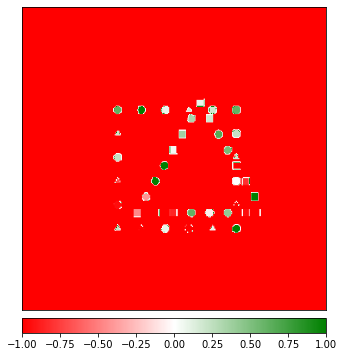

In [ ]:
normalised_big=calculate_shap(inputs[2], 2, network)

In [ ]:
normalized_choosing=copy.deepcopy(normalised_big)
dict_list=[]
for i in range (len(normalized_choosing)):
    for j in range (len(normalized_choosing[0])):
        if normalized_choosing[i][j]!=0:
            Details = ImageDetails()
            Details.analyze(image=inputs[2],show_output=False)

            pixel_details_1 = Details.pixel_analysis(x=i,y=j)
            dict_list.append(pixel_details_1)
            


In [ ]:
data_frame=pd.DataFrame(dict_list)
data_frame=data_frame.drop_duplicates()
data_frame

,color_names,shape_names,figure_ids
0,red,circle,25.0
1,blue,circle,30.0
3,red,empty,-1.0
4,red,square,13.0
13,gray,empty,-1.0
30,blue,triangle,22.0
69,blue,empty,-1.0
75,yellow,square,9.0
116,yellow,circle,28.0
123,red,square,8.0


In [ ]:
data_frame_new=copy.deepcopy(data_frame)
data_frame_new.columns
data_frame_new=data_frame_new.drop('figure_ids', axis=1)

In [ ]:
data_frame_new=data_frame_new.groupby(data_frame_new.columns.tolist(), as_index=False).size()

In [ ]:
data_frame_new

,color_names,shape_names,size
0,blue,circle,2
1,blue,empty,1
2,blue,triangle,2
3,gray,empty,1
4,red,circle,2
5,red,empty,1
6,red,square,2
7,yellow,circle,1
8,yellow,square,2


### Summary of attempts


Further investigation about global methods and their implementation will be conducted in next steps of this project.



## Articles 

### Article 1

Title:  Deep Residual Learning for Image Recognition  
Authors:  Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun  
Publisher:    2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR)  
Link: https://arxiv.org/pdf/1512.03385.pdf 

The article introduces ResNet (from 'Residual Network') CNN architectures. These are end-to-end models, possibly with many layers and rather hard to explain. However, they benefit from their depth and complexity and can achieve high scores on various datasets (including Kandinsky Patterns). The article presents a new approach to designing network architecture by using 'identity shortcuts' and building the model from various 'blocks'.

### Article 2

**Title: Axiomatic Attribution for Deep Networks** \
Authors:  Mukund Sundararajan, Ankur Taly, Qiqi Yan \
Publisher: arXiv \
Link: https://arxiv.org/pdf/1703.01365.pdf


This article introduces a new method which is called Integrated Gradients. It addresses the problem of neural networks, which is connected to attributing the predictions to the input features. What is unique about this method is that it does not change the original net and according to the authors, it is easy to implement. Authors define two new axioms, which according to them should be fulfilled by all attribution methods, and is by Integrated Gradients. The drawback of this article is that the authors do not mention solving problems with correlated features in input data.

### Article 3

**Title: “Why Should I Trust You?” Explaining the Predictions of Any Classifier** \
Authors: Marco Tulio Ribeiro, Sameer Singh, Carlos Guestrin \
Publisher: KDD '16: Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining
Link: https://arxiv.org/pdf/1602.04938.pdf

The article introduces the Local Interpretable Model agnostic Explanations method, abbreviated and commonly referred to as LIME. The main idea is to find an interpretable model that will accurately approximate black-box model locally. It is achieved by solving an optimization problem over a set of interpretable models. Moreover, the articles presents the SP-LIME method which selects a set of representative and insightful instances along with their explanations. The method is tested on a text and image classification problems using random forests and neural networks respectively. Lastly, a vast portion of the article is devoted to describing the impact of LIME explanations on trusting the model by conducting user studies. 


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bc6ece19-7b0a-4a42-9a06-463a643dea3a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>